In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import keras
from keras import layers

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# TRATAMENTO DOS DADOS E TREINAMENTO DA REDE NEURAL
---



Rede neural em python que será treinada e depois testada.

Tarefa de CLASSIFICAÇÃO, com verbos como se fosse de PREDIÇÃO.

FUNÇÕES ESSENCIAIS

In [2]:
def norm(x, dbStats):
  return ((x-dbStats['min'])/(dbStats['max']-dbStats['min']))

def db_adjustments(db):
  db = db.dropna()
  type = db.pop("type")
  db.pop("udi")
  db.pop("product_id")
  db['L'] = (type == 'L')*1.0
  db['M'] = (type == 'M')*1.0
  db['H'] = (type == 'H')*1.0
  return db

def convertClasses(db, labels, lev):
  le = preprocessing.LabelEncoder()
  lev.append(le)
  le.fit(db['failure_type'])
  db['failure_type'] = le.transform(db['failure_type'])
  dbLabels = db["failure_type"]
  labels.append(dbLabels)
  db.pop("failure_type")

TREINAMENTO DA REDE


Divide-se o BD de Treino em o banco real de Treinamento e um banco falso de teste, para verificar a eficácia do teste antes de utilizar o BD de Teste oficial.

In [3]:
db_1 = pd.read_csv('desafio_manutencao_preditiva_treino.csv')


dbTreino, test = train_test_split(db_1, test_size=0.2)
labels = []  # Armazena as labels de uma classe que contém labels. Referente a Treino e test.
lev = []  # Armazena Labels Encoders criados ao longo do código.  

Para trabalhar com os dados de forma adequada, são realizadas duas operações empacotadas em funções:
- db_adjustments remove colunas que não contribuem com a classificação (uid, product_type, )
  > A coluna type é convertida em 3 colunas de informação binária.

- convertClasses realiza a remoção dos rótulos de classe, bem como utiliza a biblioteca LabelEncoder para converter as Strings referentes a cada classe em números, como exposto abaixo.

In [4]:
dbTreino = db_adjustments(dbTreino)   # train and val adjusted and non-significant columns removed

convertClasses(dbTreino, labels, lev)

Ao analisar a distribuição de dados do dataset de acordo com as classes, é possível verificar que há muitos dados da classe 1: No Failure. 

Com isso, a operação de treinamento será afetada pelo desbalanceamento de dados entre as classes. Uma técnica muito popular e eficiente em situações assim, é de utilizar o recurso SMOTE para gerar dados similares aos dados de cada classe em desvantagem, e assim criar um dataset equilibrado.

In [5]:
# SMOTE: Equilibrate labels on dataset.
sm = SMOTE(random_state = 2)
dbTreino_eq, labelsTreino_res = sm.fit_resample(dbTreino, labels[0])

In [6]:
dbTreino_stats = dbTreino_eq.describe()
dbTreino_stats = dbTreino_stats.transpose()
dbTreino_norm = norm(dbTreino_eq, dbTreino_stats)
dbTreino_stats

,count,mean,std,min,25%,50%,75%,max
air_temperature_k,30882.0,300.479997,1.789717,295.3,299.139145,300.483308,302.068406,304.5
process_temperature_k,30882.0,310.215937,1.250229,305.8,309.300000,310.351452,311.100000,313.8
rotational_speed_rpm,30882.0,1500.935173,282.367136,1168.0,1355.000000,1411.000000,1549.000000,2874.0
torque_nm,30882.0,46.760752,14.576488,4.2,36.874343,48.613569,56.842985,76.2
tool_wear_min,30882.0,143.474095,69.559616,0.0,86.000000,162.000000,206.000000,251.0
L,30882.0,0.645412,0.411436,0.0,0.205774,0.906624,1.000000,1.0
M,30882.0,0.250692,0.375603,0.0,0.000000,0.000000,0.505387,1.0
H,30882.0,0.103896,0.266121,0.0,0.000000,0.000000,0.000000,1.0


In [7]:
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop,  
					math.floor((1+epoch)/epochs_drop))
	return lrate

def build_model():
	model = keras.Sequential([
		layers.Dense(128, activation='relu', input_shape=[len(dbTreino_eq.keys())]),
		layers.Dense(128, activation='relu'),
		layers.Dense(1)
	])
	model.compile(
								loss='mse',
									optimizer=keras.optimizers.Adam(learning_rate=1e-2),
								metrics=['mae', 'mse', 'accuracy'])
	return model

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(history):
	hist = pd.DataFrame(history.history)
	hist['epoch'] = history.epoch
	
	plt.figure()
	plt.xlabel('Epoch')
	plt.ylabel('Mean Abs Error [MPG]')
	plt.plot(hist['epoch'], hist['mae'],
						label='Train Error')
	plt.plot(hist['epoch'], hist['val_mae'],
						label = 'Val Error')
	plt.legend()

	plt.figure()
	plt.xlabel('Epoch')
	plt.ylabel('Mean Square Error [$MPG^2$]')
	plt.plot(hist['epoch'], hist['mse'],
						label='Train Error')
	plt.plot(hist['epoch'], hist['val_mse'],
						label = 'Val Error')
	plt.legend()
	plt.show()

In [8]:
model = build_model()
example_batch = dbTreino_norm[:10]
example_result = model.predict(example_batch)

1/1 [==============================] - 2s 2s/step



....................................................................................................
...........................

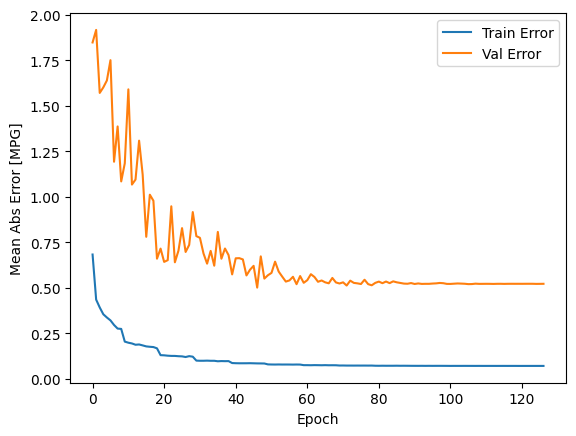

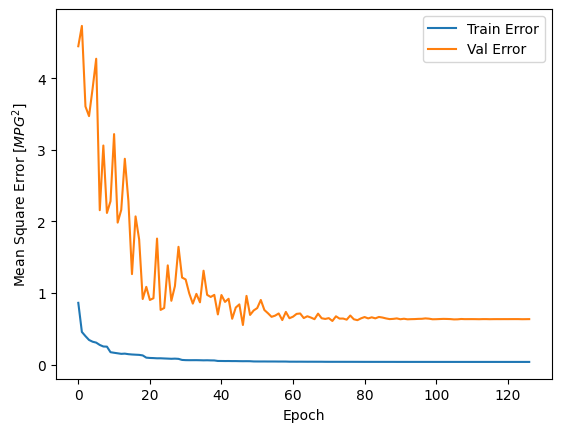

In [9]:
EPOCHS = 500
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=80)

lrate = keras.callbacks.LearningRateScheduler(step_decay)
history = model.fit( dbTreino_norm, labelsTreino_res, epochs=EPOCHS,
                    validation_split = 0.15, verbose=0, callbacks=[early_stop, PrintDot(), lrate])

plot_history(history)

# VALIDAÇÃO MANUAL: BANCO DE TESTE FAKE

20% dos dados de treinamento foram separados para serem utilizados como dados de teste, a fim de simular a situação do real banco de teste.

A presença de labels permite obter uma acurácia.

In [10]:
test = db_adjustments(test)
convertClasses(test, labels, lev)

test_fake_norm = norm(test, dbTreino_stats)
model.predict(test_fake_norm)

test_fake_predict = model.evaluate(test_fake_norm, labels[1])
test_fake_predict

42/42 [==============================] - 0s 2ms/step - loss: 0.3014 - mae: 0.1996 - mse: 0.3014 - accuracy: 0.9618


[0.3014449179172516,
 0.19958491623401642,
 0.3014449179172516,
 0.9617691040039062]

In [11]:
print("Acurácia verificada de " + str(round(test_fake_predict[3]*100, 3)) + "%.")

Acurácia verificada de 96.177%.


# CHALLENGE 3 - TESTE

In [21]:
dbTeste = pd.read_csv('desafio_manutencao_preditiva_teste.csv')

dbTeste = db_adjustments(dbTeste)
dbTeste_norm = norm(dbTeste, dbTreino_stats)

dbTeste_pred = model.predict(dbTeste_norm)
test_predictions = model.predict(dbTeste_norm).flatten()

105/105 [==============================] - 0s 2ms/step


In [22]:
## Convert from number to classes

# 1: Round numbers
predicted_classes_numbers = np.int_(np.round_(dbTeste_pred))

# Evitar erros de arrendondamento
predicted_classes_numbers [predicted_classes_numbers < 0] = 0
predicted_classes_numbers [predicted_classes_numbers > 5] = 5

# 2: Convert
# Aplica a regra para converter de volta, definida no Label Encoder 1.
predicted_classes = lev[0].inverse_transform(predicted_classes_numbers)

d:\trab2\ProcessosSel\indicium-challenge-3\venv\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
# len(test_predictions)
# rowNumber = np.arange(len(test_predictions))
# data = {'rowNumber': rowNumber , 'predictedValues': predicted_classes }
# predicted = pd.DataFrame(data, columns=['rowNumber','predictedValues'])

predicted = pd.DataFrame(predicted_classes, columns=['predictedValues'])
predicted.index.name = 'rowNumber'
predicted = predicted.rename_axis(index='rowNumber', columns="rowNumber")
predicted.head()

rowNumber,predictedValues
rowNumber,
0,No Failure
1,No Failure
2,No Failure
3,No Failure
4,No Failure


In [26]:
predicted.to_csv('predicted.csv')